In [3]:
import torch
import torch.nn as nn
from torch.fft import fft2, ifft2
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from skimage import data, color  # For skimage's sample images

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [4]:
###############################################################################
# FFTBlur Class
###############################################################################
class FFTBlur(nn.Module):
    def __init__(self, blur_sigmas, image_size, device):
        """
        Args:
            blur_sigmas (list): List of sigma values for blur.
            image_size (int): Assumed square image dimension.
            device (torch.device): Device to run the calculations (CPU or CUDA).
        """
        super(FFTBlur, self).__init__()
        # Convert blur_sigmas to a tensor on the specified device
        self.blur_sigmas = torch.tensor(blur_sigmas, dtype=torch.float32, device=device)
        self.image_width = image_size
        self.image_height = image_size
        self.device = device

        # Create the spatial kernel and its "flipped" version in frequency domain
        self.H_bar = self.create_kernel(self.image_width, self.image_height)
        self.H_tilde = self.matrix_flip(self.H_bar)
        self.fft2_H_tilde = fft2(self.H_tilde)

    def destination_center(self, width, height):
        """
        Computes the 'destination' center for the kernel.
        """
        (cw1, ch1) = (width // 2 + 1, height // 2 + 1)
        return (cw1, ch1)

    def source_center(self, width, height):
        """
        Computes the 'source' center for the kernel.
        """
        (cw1, ch1) = self.destination_center(width, height)
        (cw2, ch2) = (width - cw1, height - ch1)
        return (cw2, ch2)

    def create_kernel(self, width, height):
        """
        Builds a 2D kernel H_bar in the spatial domain.
        """
        # Example 3x3 kernel
        H = 1/8 * torch.tensor([[0, 1, 0],
                                [1, 4, 1],
                                [0, 1, 0]], dtype=torch.float32, device=self.device)

        (cw2, ch2) = self.source_center(width, height)
        H_bar = torch.zeros((width, height), dtype=torch.float32, device=self.device)
        H_bar[cw2-1:cw2+2, ch2-1:ch2+2] = H
        return H_bar

    def matrix_flip(self, H_bar):
        """
        Reorganizes the kernel so that the top-left corner is the center of the kernel.
        """
        (w, h) = H_bar.shape
        (cw1, ch1) = self.destination_center(w, h)
        (cw2, ch2) = self.source_center(w, h)

        H_tilde = torch.zeros_like(H_bar)
        H_tilde[0:cw1,   0:ch1]   = H_bar[cw2:w,   ch2:h]
        H_tilde[cw1:w,   0:ch1]   = H_bar[0:cw2,   ch2:h]
        H_tilde[0:cw1,   ch1:h]   = H_bar[cw2:w,   0:ch2]
        H_tilde[cw1:w,   ch1:h]   = H_bar[0:cw2,   0:ch2]
        return H_tilde

    def forward(self, x, fwd_steps):
        """
        Applies the blur in the frequency domain.

        Args:
            x (Tensor): Input image tensor, shape (N, C, H, W) or (C, H, W).
            fwd_steps (int): Index into self.blur_sigmas to choose the sigma.

        Returns:
            Tensor: The blurred image.
        """
        # Retrieve the chosen sigma value
        sigma_value = self.blur_sigmas[fwd_steps]

        # Reshape sigma_value for broadcasting
        if len(x.shape) == 4:  # (N, C, H, W)
            sigma_value = sigma_value.view(1, 1, 1, 1)
        elif len(x.shape) == 3:  # (C, H, W)
            sigma_value = sigma_value.view(1, 1, 1)

        # Raise kernel to the power of sigma in frequency domain
        fft2_H_tilde_t = self.fft2_H_tilde[None, None, ...] ** sigma_value

        # Perform convolution by multiplication in frequency domain
        return ifft2(fft2_H_tilde_t * fft2(x)).real



In [5]:
###############################################################################
# Utility Functions
###############################################################################
def load_and_preprocess_skimage_astronaut(size=(128, 128)):
    """
    Loads the skimage 'astronaut' image, converts to RGB if needed,
    resizes it, and returns a tensor of shape (1, 3, H, W) in [0,1].
    Also returns the PIL image for display purposes.
    """
    # Get the sample astronaut image
    imgnp = data.astronaut()  # shape: (512, 512, 3), dtype=uint8, by default
    # Convert numpy array to PIL
    pil_img = Image.fromarray(imgnp).convert("RGB")
    # Resize the PIL image
    pil_img = pil_img.resize(size)
    # Convert to tensor [0,1]
    transform = T.ToTensor()
    img_tensor = transform(pil_img).unsqueeze(0)
    return img_tensor, pil_img


def blur_image(model, input_tensor, sigma_index=0):
    """
    Applies the FFT blur model to the input tensor using the specified sigma index.
    Returns the blurred tensor in shape (N, C, H, W).
    """
    with torch.no_grad():
        blurred = model(input_tensor, fwd_steps=sigma_index)
    return blurred


def display_side_by_side(original_pil, blurred_tensor, sigma_value):
    """
    Displays the original and blurred images side by side.
    """
    # Convert blurred_tensor -> numpy
    blurred_np = blurred_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()

    # Clamp to [0,1]
    blurred_np = np.clip(blurred_np, 0, 1)

    # Convert original PIL image to numpy (uint8)
    original_np = np.array(original_pil)

    # Convert blurred image to uint8
    blurred_np_8u = (blurred_np * 255).astype(np.uint8)

    # Display
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    axes[0].imshow(original_np)
    axes[0].axis("off")
    axes[0].set_title("Original Image")

    axes[1].imshow(blurred_np_8u)
    axes[1].axis("off")
    axes[1].set_title(f"Blurred (sigma={sigma_value})")

    plt.tight_layout()
    plt.show()


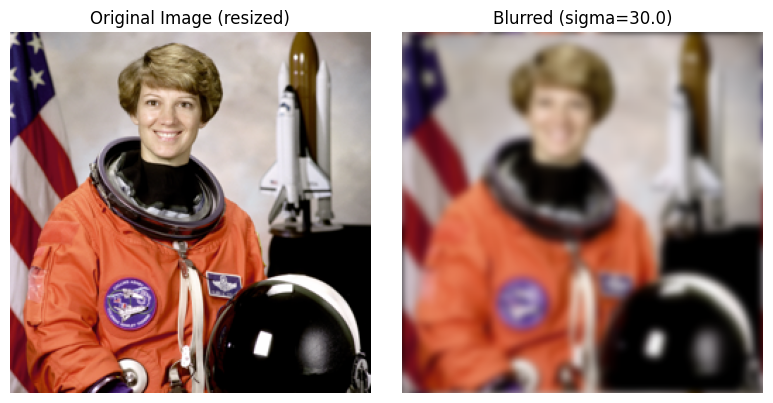

In [15]:
# Load and preprocess the 'astronaut' image from skimage
img_tensor, pil_img = load_and_preprocess_skimage_astronaut(size=(256, 256))

# Set a single sigma value in a list
blur_sigma = 30.0

# Create the FFTBlur model
model = FFTBlur(
    blur_sigmas=[blur_sigma],
    image_size=img_tensor.shape[-1],
    device=device
).to(device)

# Move the input tensor to the chosen device
img_tensor = img_tensor.to(device)

# Blur the image (we only have one sigma, so index=0)
blurred_tensor = blur_image(model, img_tensor, sigma_index=0)

# Display both images side by side
display_side_by_side(pil_img, blurred_tensor, sigma_value=blur_sigma)
